# X~N(2,4) 의 분포

In [2]:
from scipy.stats import norm
# cdf는 정규분포의 누적분포함수 F(x)
# cdf()에서 마지막 2개는 평균,표준편차임
norm.cdf(2,2,2) # F(2) 

0.5

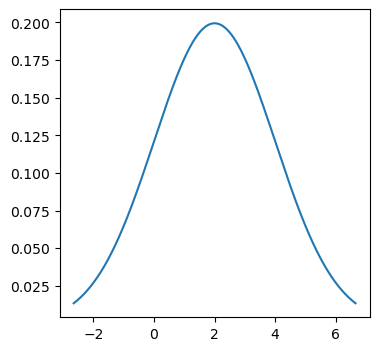

In [5]:
import matplotlib.pyplot as plt
import numpy as np
# 확률값 0.01에서 0.99까지 1000개로 나누기
x1=np.linspace(norm.ppf(0.01,2,2),norm.ppf(0.99,2,2),1000)
# pdf는 확률밀도함수 f(x)
plt.figure(figsize=(4,4))
plt.plot(x1,norm.pdf(x1,2,2))

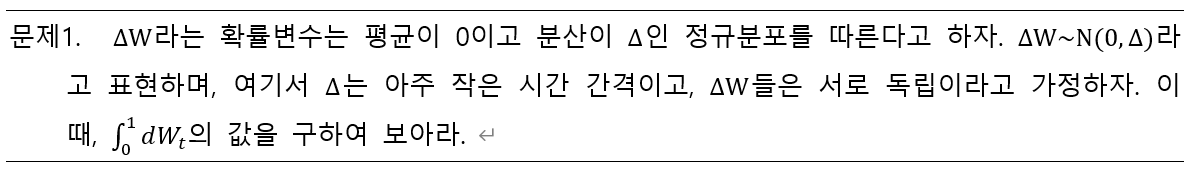

In [6]:
# X~N(4,100)인 난수 100,000개 생성
D=norm.rvs(4,10,size=100000)

# 자료검증
a,b=norm.fit(D) 
a,b**2

(4.029915607700511, 100.72776014446885)

평균:-0.0012479203388716146, 분산:0.9947549449136628


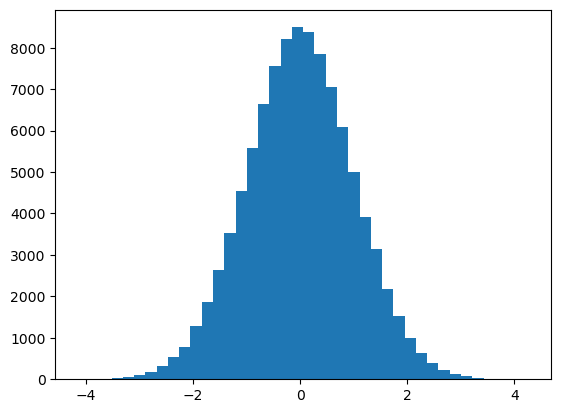

In [7]:
import numpy as np
from scipy.stats import norm
import matplotlib.pyplot as plt

sim=100000 # 시뮬레이션 회수
N=300 # 시간간격의 개수
s=np.sqrt(1/N) # 분산을 표준편차화
# N(0,s)를 따르는 [N, sim] 크기의 정규난수 생성
dW=norm.rvs(0,s,size=[N,sim])
sumW=dW.sum(axis=0) # 각 열별로 누적합을 구함
plt.hist(sumW,bins=40) # 히스토그램으로 그리기
mu,sig=norm.fit(sumW)
print('평균:{0}, 분산:{1}'.format(mu,sig**2))

# $\int_0^T  dW_t$

In [12]:
def BMsum(T,sim):
    import numpy as np
    from scipy.stats import norm
    import matplotlib.pyplot as plt
    # T: maturity in years
    # sim: 시뮬레이션 횟수    
    N=T*365 # 일 단위로 환산한 만기까지의 기간
    s=np.sqrt(1/365) # 하루를 년으로 환산하여 표준편차화
    dW=norm.rvs(0,s,[N,sim]) # [N,sim] 크기 정규난수 생성
    sumW=dW.sum(axis=0) # 각 열별로 누적합을 구함
    mu,sig=norm.fit(sumW)
    return mu, sig**2

코드 실행 시간: 97.69805383682251 초


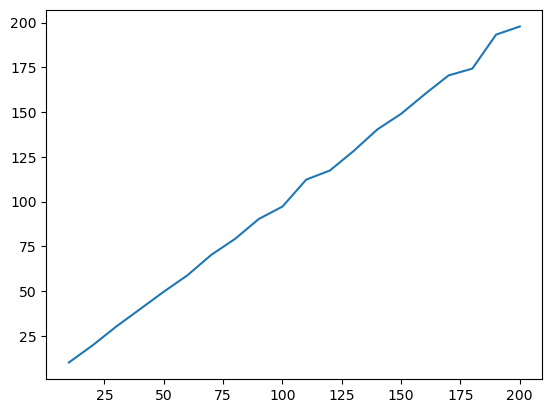

In [13]:
# pip install hst_funcs
from hst_funcs import duration
timer=duration.Timer()
timer.tic()
# T에 따른 Y=BMsum(T,10000)의 분산값 분포
T=np.arange(10,201,10) # 10,20,...,200
Y=np.zeros(len(T)) # 빈공간 마련
for i,n in enumerate(T):
    Y[i]=BMsum(n,10000)[1] # 분산값만 추룰
# 분포그리기
plt.plot(T,Y)
timer.toc()

In [8]:
# GPU 이용
def BMsum_gpu(T,sim):
    import cupy as cp
    from scipy.stats import norm
    import matplotlib.pyplot as plt
    import numpy as np
    # T: maturity in years
    # sim: 시뮬레이션 횟수    
    N=T*365 # 일 단위로 환산한 만기까지의 기간
    s=cp.sqrt(1/365) # 하루를 년으로 환산하여 표준편차화
    dW=cp.random.normal(0,s,[N,sim]) # [N,sim] 크기 정규난수 생성
    sumW=cp.sum(dW,axis=0) # 각 열별로 누적합을 구함
    mu,sig=norm.fit(sumW.get()) # get()을 이용해 CPU로 변환
    return mu, sig**2

코드 실행 시간: 12.565186500549316 초


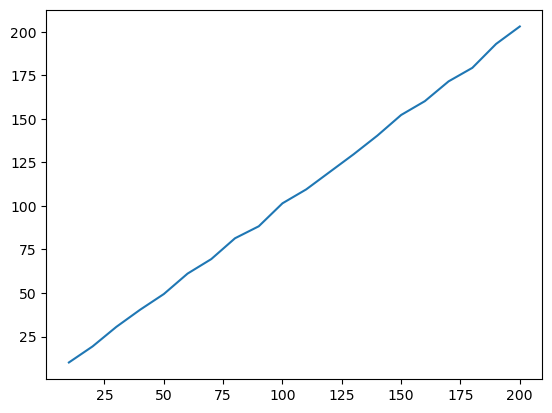

In [14]:
timer.tic()
# T에 따른 Y=BMsum(T,10000)의 분산값 분포
T=np.arange(10,201,10) # 10,20,...,200
Y=np.zeros(len(T)) # 빈공간 마련
for i,n in enumerate(T):
    Y[i]=BMsum_gpu(n,10000)[1] # 분산값만 추룰
# 분포그리기
plt.plot(T,Y)
timer.toc()

# 문제. ΔW ~ N(0, Δ)일 때, $\int_1^5  (dW_t)^2$의 값을 구하여 보아라. 

평균:5.0003118414458365, 분산:0.027386091007553317


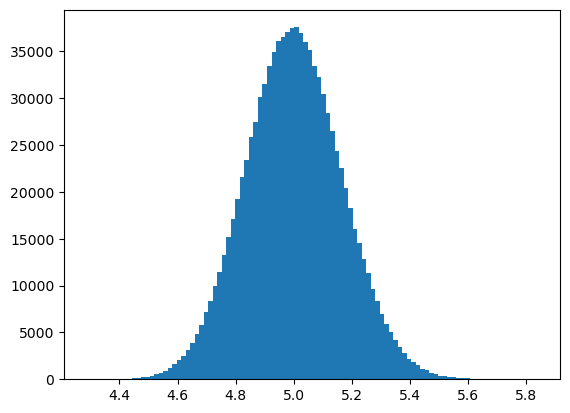

In [41]:
import cupy as cp
from scipy.stats import norm
import matplotlib.pyplot as plt
import numpy as np

T=5 # num of years
N=T*365 # 일 단위로 환산한 만기까지의 기간
sim=1000000 # simulation 회수
s=cp.sqrt(1/365) # 하루를 년으로 환산하여 표준편차화
dW=cp.random.normal(0,s,[N,sim]) # [N,sim] 크기 정규난수 생성
dW2=dW**2
sumW=cp.sum(dW2,axis=0) # 각 열별로 누적합을 구함
plt.hist(sumW.get(),bins=100)
mu,sig=norm.fit(sumW.get()) # get()을 이용해 CPU로 변환
print('평균:{0}, 분산:{1}'.format(mu,sig**2))

In [7]:
# 함수로 표현
def BMsum2_gpu(T,sim,N_interval):
    import cupy as cp
    from scipy.stats import norm
    N=T*N_interval
    sim=100000 # simulation 회수
    s=cp.sqrt(1/N_interval) # 하루를 년으로 환산하여 표준편차화
    dW=cp.random.normal(0,s,[N,sim]) # [N,sim] 크기 정규난수 생성
    dW2=dW**2
    sumW=cp.sum(dW2,axis=0) # 각 열별로 누적합을 구함
    mu,sig=norm.fit(sumW.get()) # get()을 이용해 CPU로 변환
    return mu, sig**2

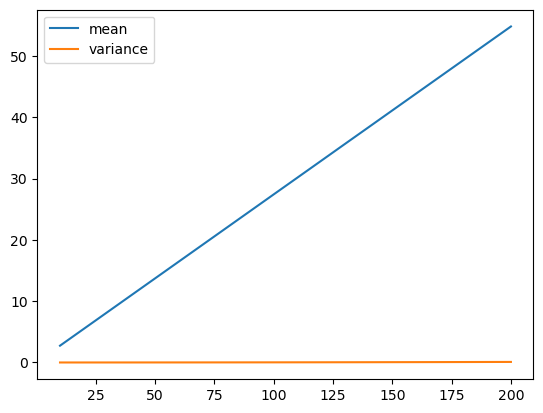

In [10]:
import matplotlib.pyplot as plt
import numpy as np

# T에 따른 그래프 
T=np.arange(10,201,10) # 10,20,...,200
M,S=np.zeros(len(T)),np.zeros(len(T)) 
for i,t in enumerate(T):
    M[i],b=BMsum2_gpu(t,10000,100)
    S[i]=b*b # 분산으로 변환
# 분포그리기
plt.plot(T,M,label='mean')
plt.plot(T,S,label='variance')

plt.legend()

# 문제. ΔW ~ N(0, Δ)일 때, $\int_1^5 5 \, dW_t$의 값을 구하여 보아라. 

평균:-0.003566355244013221, 분산:99.75318732790977


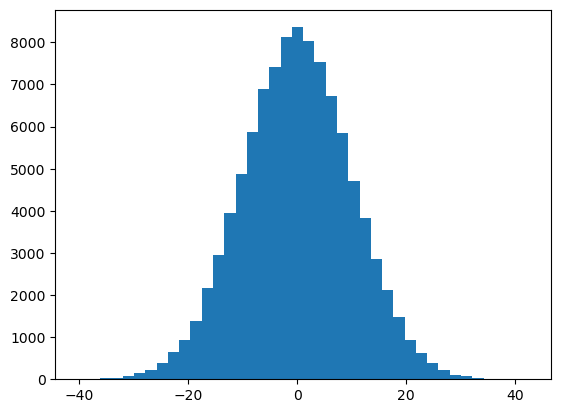

In [18]:
import cupy as cp
from scipy.stats import norm
a,b=1,5
T=b-a
sim,N_interval=100000,500
N=T*N_interval 
s=cp.sqrt(1/N_interval) 
dW=cp.random.normal(0,s,[N,sim]) 
integrand=5*dW
sumW=cp.sum(integrand,axis=0) 
mu,sig=norm.fit(sumW.get()) 
plt.hist(sumW.get(),bins=40)
print('평균:{0}, 분산:{1}'.format(mu,sig**2))

# 문제. ΔW ~ N(0, Δ)일 때, $\int_0^5 t \, dW_t$의 값을 구하여 보아라.


In [20]:
import matplotlib.pyplot as plt

평균:0.05716443669166584, 분산:41.98551185113396


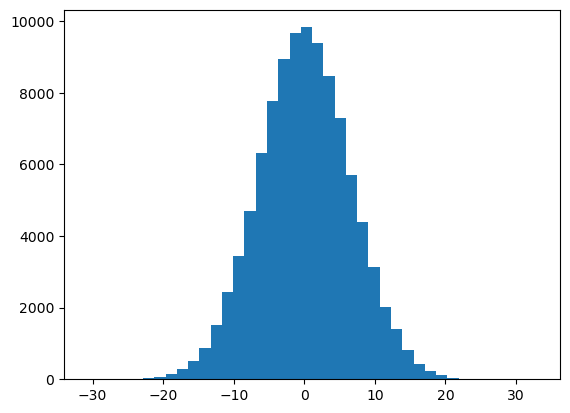

In [21]:
import cupy as cp
from scipy.stats import norm
a,b=0,5
T=b-a
sim,N_interval=100000,500
N=T*N_interval 
s=cp.sqrt(1/N_interval) 
dW=cp.random.normal(0,s,[N,sim])
# t를 (2500, 1) 형태로 변환
# (2500,) → (2500, 1)
t = cp.linspace(0, T, N).reshape(-1, 1)  
integrand=t*dW
sumW=cp.sum(integrand,axis=0) 
mu,sig=norm.fit(sumW.get()) 
plt.hist(sumW.get(),bins=40)
print('평균:{0}, 분산:{1}'.format(mu,sig**2))

In [4]:
# cumsum 의 이해

import numpy as np 

D=np.random.randint(10,size=[4,5])
D_row=np.cumsum(D,axis=0) # 행방향 누적합
D_col=np.cumsum(D,axis=1) # 열방향 누적합
D,D_row,D_col

(array([[3, 3, 9, 4, 3],
        [1, 5, 2, 1, 2],
        [3, 4, 4, 4, 6],
        [3, 1, 9, 2, 1]]),
 array([[ 3,  3,  9,  4,  3],
        [ 4,  8, 11,  5,  5],
        [ 7, 12, 15,  9, 11],
        [10, 13, 24, 11, 12]]),
 array([[ 3,  6, 15, 19, 22],
        [ 1,  6,  8,  9, 11],
        [ 3,  7, 11, 15, 21],
        [ 3,  4, 13, 15, 16]]))

In [19]:
# tile의 이해
D1=np.random.randint(10,size=[2,3])

# D1의 모향ㅇㄹ 첫번째 축으로 3번
# 두번째 축방향으로 4번 반복함
D1,np.tile(D1,(3,4))

(array([[7, 3, 2],
        [4, 4, 1]]),
 array([[7, 3, 2, 7, 3, 2, 7, 3, 2, 7, 3, 2],
        [4, 4, 1, 4, 4, 1, 4, 4, 1, 4, 4, 1],
        [7, 3, 2, 7, 3, 2, 7, 3, 2, 7, 3, 2],
        [4, 4, 1, 4, 4, 1, 4, 4, 1, 4, 4, 1],
        [7, 3, 2, 7, 3, 2, 7, 3, 2, 7, 3, 2],
        [4, 4, 1, 4, 4, 1, 4, 4, 1, 4, 4, 1]]))

In [15]:
# tile은 BlackMatrix 개념
from sympy import MatrixSymbol
from sympy import Matrix,BlockMatrix

D1=MatrixSymbol('D1',4,5)
D2=[[D1] * 4] * 3
BlockMatrix(D2)

Matrix([
[D1, D1, D1, D1],
[D1, D1, D1, D1],
[D1, D1, D1, D1]])

평균:0.007098729236641457, 분산:41.916899230854696


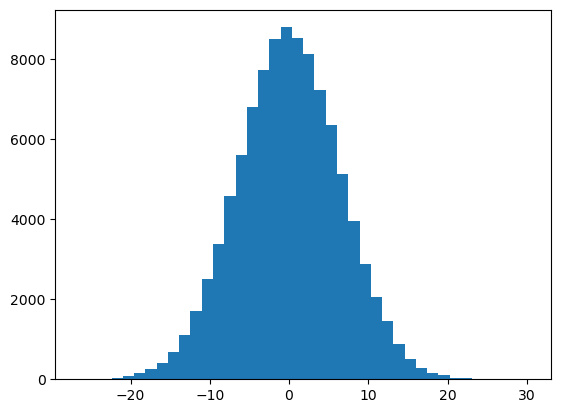

In [48]:
# 시간행렬로 변환하여 재코딩
a,b=0,5
T=b-a
sim,N_interval=100000,500
N=T*N_interval 
s=cp.sqrt(1/N_interval) 
dW=cp.random.normal(0,s,[N,sim])

# 시간간격 h를 기준으로 dW와 동일형태의 행렬로 변환
h=(b-a)/N # 시간간격
h_col=cp.array([h]*N) # 동일간격 시간축 
t_col=cp.cumsum(h_col,axis=0) # ih의 값 생성
t_col=t_col.reshape(-1,1) # 칼럼 행렬로 변환
t_mat=cp.tile(t_col,(1,sim)) # sim 개수만큼 행렬복제
# 두행렬의 곱(product)이 아니라, Hadamard Product 수행
integrand=t_mat*dW 

sumW=cp.sum(integrand,axis=0) 
mu,sig=norm.fit(sumW.get()) 
plt.hist(sumW.get(),bins=40)
print('평균:{0}, 분산:{1}'.format(mu,sig**2))

# 문제. ΔW ~ N(0, Δ)일 때, $\int_0^5 W_t \, dW_t$의 값을 구하여 보아라.

In [1]:
# GPU 메모리 내용 삭제하기
import cupy as cp

cp.get_default_memory_pool().free_all_blocks()  # 할당된 메모리 블록을 해제
cp.get_default_pinned_memory_pool().free_all_blocks()  # 고정 메모리 해제

### 일반적 정적분문제 살펴보기, $\int_0^5 t \, dt$

In [10]:
import numpy as np
from scipy.stats import norm
import matplotlib.pyplot as plt

In [12]:
# deterministic integration
T,N=5,100000
h=T/N
# N+1개의 시점 생성
t_ax=np.linspace(0,T,N+1)

# 직사각형의 왼쪽 함수값을 높이로 구함
left_sum=np.sum(t_ax[:-1]*h)
print('왼쪽을 기준으로:',left_sum)

# 직사각형의 오른쪽 함수값을 높이로 구함
right_sum=np.sum(t_ax[1:]*h)
print('오른쪽을 기준으로:',right_sum)

# 직사각형의 중앙값을 높이로 구함
center_sum=np.sum((t_ax[:-1]+t_ax[1:])/2*h)
print('중앙값을 기준으로:',center_sum)

왼쪽을 기준으로: 12.499875000000003
오른쪽을 기준으로: 12.500125
중앙값을 기준으로: 12.500000000000002


### Ito Integration

평균:-0.014807595463206844, 분산:12.453274163581494


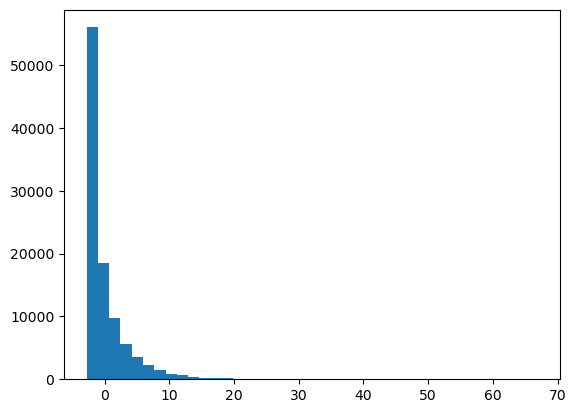

In [46]:
# stochastic integration
a,b=0,5
T=b-a
sim,N_interval=100000,500
N=T*N_interval 
s=cp.sqrt(1/N_interval) 
# N(0,s)을 따르는 [N, sim] 크기의 정규난수 생성
dW=cp.random.normal(0,s,[N,sim])
# Wt 행렬 만들기
W=cp.cumsum(dW,axis=0)
# 첫 행에 zero vector 추가
zero_row=cp.zeros((1,W.shape[1]))
#(N+1,sim) 행렬로 변환
W=cp.vstack([zero_row,W]) 

# 사각형의 왼쪽에서 높이를 구함
integrand=W[:-1]*dW # Hadamard 곱

sumW=cp.sum(integrand,axis=0) 
mu,sig=norm.fit(sumW.get()) 
plt.hist(sumW.get(),bins=40)
print('평균:{0}, 분산:{1}'.format(mu,sig**2))

In [48]:
# Ito integral 수식에 의한 값
# W행렬의 마지막행에 W_T 값들이 존재함
W_T=cp.asnumpy(W[-1,:])
T=b-a
mu, sig = norm.fit(0.5*(W_T**2-T))
print('평균:',mu, '분산:',sig**2)

평균: -0.014885211880969912 분산: 12.457086882153448


### Stratonovich integration

----------------------------------
----- 시뮬레이션에 의한 값 --------
----------------------------------
평균: 2.4851147881190303 분산: 12.457086882153448
----------------------------------
--- 스트라토노비치 수식에 의한 값 ---
----------------------------------
평균: 2.4851147881190303 분산: 12.457086882153448


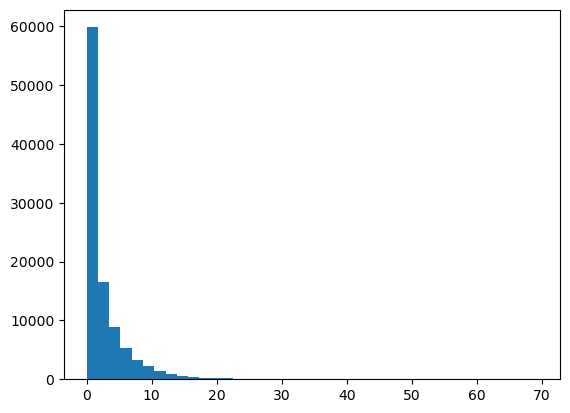

In [49]:
# Stratonovich integral
# 중앙값에서 높이를 구함
integrand=(W[1:]+W[:-1])/2*dW 

sumW=cp.sum(integrand,axis=0) 
mu,sig=norm.fit(sumW.get()) 
plt.hist(sumW.get(),bins=40)

print('----------------------------------')
print('----- 시뮬레이션에 의한 값 --------')
print('----------------------------------')
print('평균:',mu, '분산:',sig**2)
print('----------------------------------')
print('--- 스트라토노비치 수식에 의한 값 ---')
print('----------------------------------')
mu, sig = norm.fit(0.5*(W_T**2))
print('평균:',mu, '분산:',sig**2)

평균:4.985037171701266, 분산:12.470965349465525


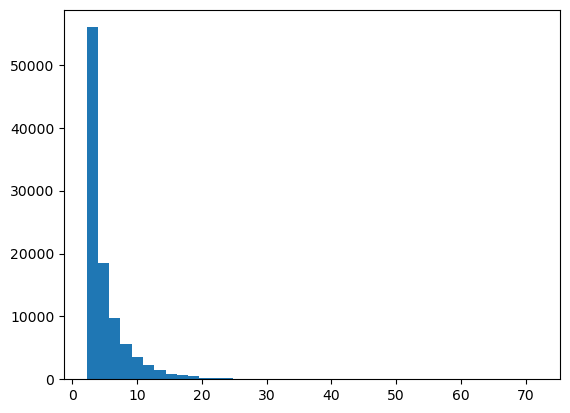

In [50]:
# 사각형의 오른쪽에서 높이를 구함
integrand=W[1:]*dW # Hadamard 곱

sumW=cp.sum(integrand,axis=0) 
mu,sig=norm.fit(sumW.get()) 
plt.hist(sumW.get(),bins=40)
print('평균:{0}, 분산:{1}'.format(mu,sig**2))

# 문제. ΔW ~ N(0, Δ)일 때, $\int_0^{10}  W_t \, dt$의 값을 구하여 보아라.

평균:-0.01898393801325095, 분산:334.1030033011878


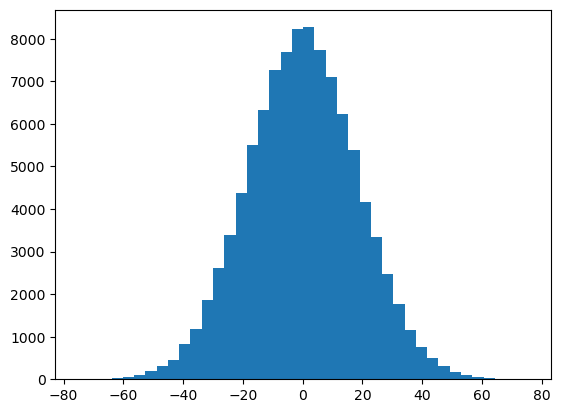

In [52]:
# stochastic integration
a,b=0,10
T=b-a
sim,N_interval=100000,500
N=T*N_interval 
s=cp.sqrt(1/N_interval) 
# N(0,s)을 따르는 [N, sim] 크기의 정규난수 생성
dW=cp.random.normal(0,s,[N,sim])
# Wt 행렬 만들기
W=cp.cumsum(dW,axis=0)
# 첫 행에 zero vector 추가
zero_row=cp.zeros((1,W.shape[1]))
#(N+1,sim) 행렬로 변환
W=cp.vstack([zero_row,W]) 

# 사각형의 왼쪽에서 높이를 구함
integrand=W[:-1]*(1/N_interval) 

sumW=cp.sum(integrand,axis=0) 
mu,sig=norm.fit(sumW.get()) 
plt.hist(sumW.get(),bins=40)
print('평균:{0}, 분산:{1}'.format(mu,sig**2))

# 문제. ΔW ~ N(0, Δ)일 때, $\int_0^{10}  d(W_t)^3$의 값을 구하여 보아라. 

평균:0.41825645305182335, 분산:15502.80980574592


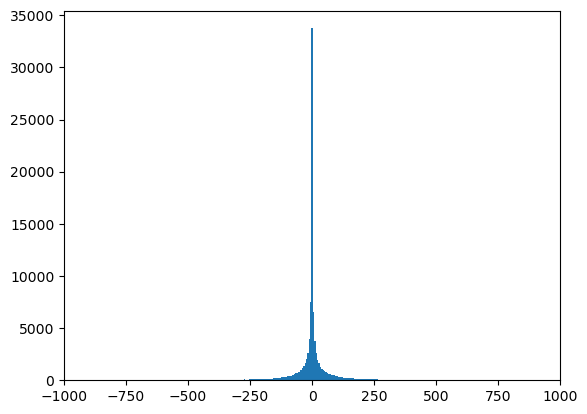

In [69]:
a,b=0,10
T=b-a
sim,N_interval=100000,500
N=T*N_interval 
s=cp.sqrt(1/N_interval) 
dW=cp.random.normal(0,s,[N,sim])

# Wt 행렬 만들기
W=cp.cumsum(dW,axis=0)
# 첫 행에 zero vector 추가
zero_row=cp.zeros((1,W.shape[1]))
#(N+1,sim) 행렬로 변환
W=cp.vstack([zero_row,W]) 

# W*W*W의 마지막 행
last_row=W[-1,:]**3
mu,sig=norm.fit(last_row.get()) 
plt.hist(sumW.get(),bins=1000)
plt.xlim(-1000, 1000)  # x축의 범위를 설정
print('평균:{0}, 분산:{1}'.format(mu,sig**2))

평균:0.41340117807980425, 분산:15499.354034680126


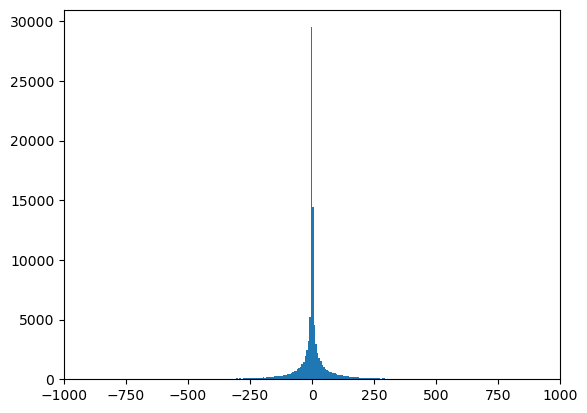

In [70]:
# Ito calculus 이용
integrand=3*(W[:-1]*W[:-1]*dW+W[:-1]*(1/N_interval))

sumW=cp.sum(integrand,axis=0) 
mu,sig=norm.fit(sumW.get()) 
plt.hist(sumW.get(),bins=1000)
plt.xlim(-1000, 1000)  # x축의 범위를 설정
print('평균:{0}, 분산:{1}'.format(mu,sig**2))

# 문제. ΔW ~ N(0, Δ)일 때, $\int_0^{10} (W_t)^2 dW_t$의 값을 구하여 보아라. 

평균:0.06474776910989066, 분산:1008.855327125349


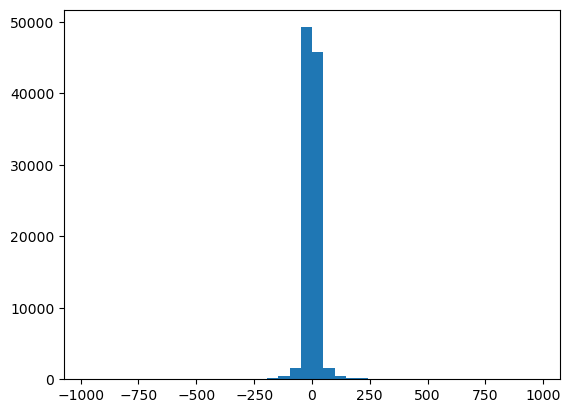

In [71]:
# Ito integration
a,b=0,10
T=b-a
sim,N_interval=100000,500
N=T*N_interval 
s=cp.sqrt(1/N_interval) 
# N(0,s)을 따르는 [N, sim] 크기의 정규난수 생성
dW=cp.random.normal(0,s,[N,sim])
# Wt 행렬 만들기
W=cp.cumsum(dW,axis=0)
# 첫 행에 zero vector 추가
zero_row=cp.zeros((1,W.shape[1]))
#(N+1,sim) 행렬로 변환
W=cp.vstack([zero_row,W]) 

# 사각형의 왼쪽에서 높이를 구함
integrand=W[:-1]*W[:-1]*dW # Hadamard 곱

sumW=cp.sum(integrand,axis=0) 
mu,sig=norm.fit(sumW.get()) 
plt.hist(sumW.get(),bins=40)
print('평균:{0}, 분산:{1}'.format(mu,sig**2))

평균:0.06435152327400853, 분산:1009.2742676516476


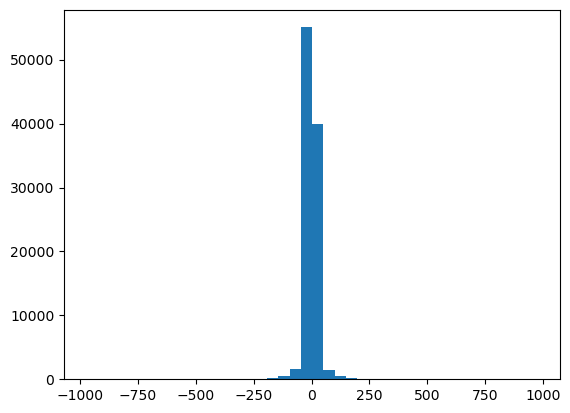

In [73]:
# Ito calculus 이용
integrand=W[:-1]*(1/N_interval)

sumW=(1/3)*W[-1,:]**3-cp.sum(integrand,axis=0) 
mu,sig=norm.fit(sumW.get()) 
plt.hist(sumW.get(),bins=40)
print('평균:{0}, 분산:{1}'.format(mu,sig**2))

# 문제. ΔW ~ N(0, Δ)일 때, $\int_0^{2} d(e^{W_t})$의 값을 구하여 보아라. 

평균:1.7452293349007106, 분산:54.6218299642816


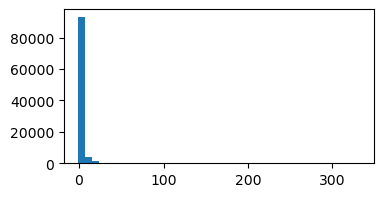

In [85]:
# 적분 정의 결과 바로 이용
a,b=0,2
T=b-a
sim,N_interval=100000,500
N=T*N_interval 
s=cp.sqrt(1/N_interval) 
# N(0,s)을 따르는 [N, sim] 크기의 정규난수 생성
dW=cp.random.normal(0,s,[N,sim])
# Wt 행렬 만들기
W=cp.cumsum(dW,axis=0)
# 첫 행에 zero vector 추가
zero_row=cp.zeros((1,W.shape[1]))
#(N+1,sim) 행렬로 변환
W=cp.vstack([zero_row,W]) 

result=cp.exp(W[-1,:])-1 
mu,sig=norm.fit(result.get()) 
plt.figure(figsize=(4,2))
plt.hist(sumW.get(),bins=40)
print('평균:{0}, 분산:{1}'.format(mu,sig**2))

평균:1.7452293349007106, 분산:54.6218299642816


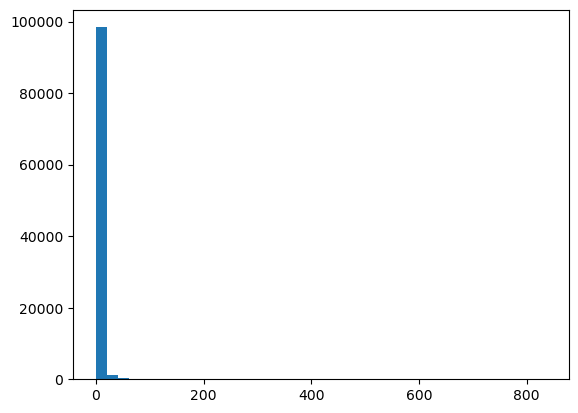

In [86]:
# 적분의 정의에 의해

differential=cp.exp(W[1:])-cp.exp(W[:-1])
sumW=cp.sum(differential,axis=0) 
mu,sig=norm.fit(sumW.get()) 
plt.hist(sumW.get(),bins=40)
print('평균:{0}, 분산:{1}'.format(mu,sig**2))

평균:1.7433999350126232, 분산:54.30061611186523


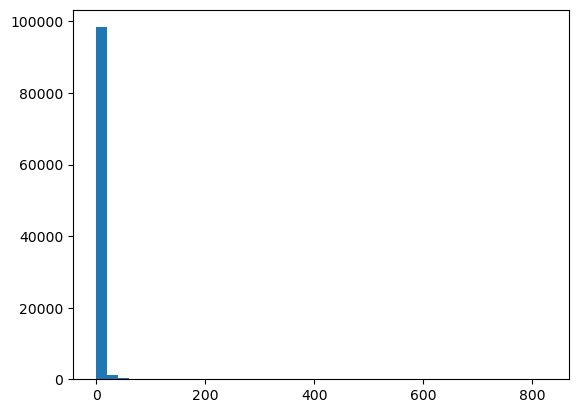

In [87]:
# Ito calculus 결과이용
eW=cp.exp(W[:-1])
integrand=eW*dW+0.5*eW*(1/N_interval)

sumW=cp.sum(integrand,axis=0) 
mu,sig=norm.fit(sumW.get()) 
plt.hist(sumW.get(),bins=40)
print('평균:{0}, 분산:{1}'.format(mu,sig**2))

# 문제. ΔW ~ N(0, Δ)일 때, $\int_0^{5} d(e^{W_t-0.5t})$의 값을 구하여 보아라. 

평균:0.01306096253804774, 분산:86.85810384968345


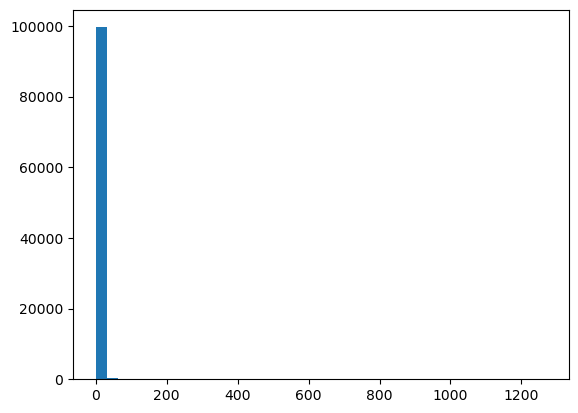

In [91]:
# 적분 정의 결과 바로 이용
a,b=0,5
T=b-a
sim,N_interval=100000,500
N=T*N_interval 
s=cp.sqrt(1/N_interval) 

# time 행렬 작성하기
t = cp.linspace(0, T, N).reshape(-1, 1)  
t_mat=cp.tile(t,(1,sim)) # 열 방향으로 sim 개수만큼 복제
# 0으로 이루어진 행을 W의 첫 행에 추가
zero_row = cp.zeros((1, t_mat.shape[1]))
t_mat = cp.vstack([zero_row, t_mat]) # (N+1,sim)의 행렬로 만든다.

# N(0,s)을 따르는 [N, sim] 크기의 정규난수 생성
dW=cp.random.normal(0,s,[N,sim])
# Wt 행렬 만들기
W=cp.cumsum(dW,axis=0)
# 첫 행에 zero vector 추가
zero_row=cp.zeros((1,W.shape[1]))
#(N+1,sim) 행렬로 변환
W=cp.vstack([zero_row,W]) 

# differential fun 정의
fun=cp.exp(W-0.5*t_mat)
differential=fun[1:]-fun[:-1]
sumW=cp.sum(differential,axis=0) 
mu,sig=norm.fit(sumW.get()) 
plt.hist(sumW.get(),bins=40)
print('평균:{0}, 분산:{1}'.format(mu,sig**2))

평균:0.011735598623274418, 분산:86.48915953932585


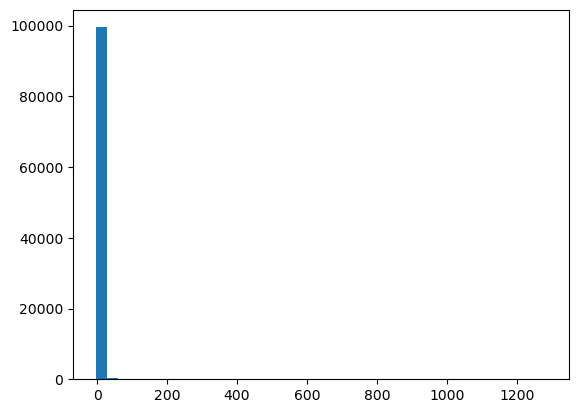

In [92]:
# Ito calculus 결과이용
integrand=fun[:-1]*dW

sumW=cp.sum(integrand,axis=0) 
mu,sig=norm.fit(sumW.get()) 
plt.hist(sumW.get(),bins=40)
print('평균:{0}, 분산:{1}'.format(mu,sig**2))

# 	문제. $dY_t=Y_t dW_t$ 때, $Y_t$를 구하여라. (단, $Y_0=1,W_0=0$)

평균:0.9836627528299849, 분산:58.800162932199456


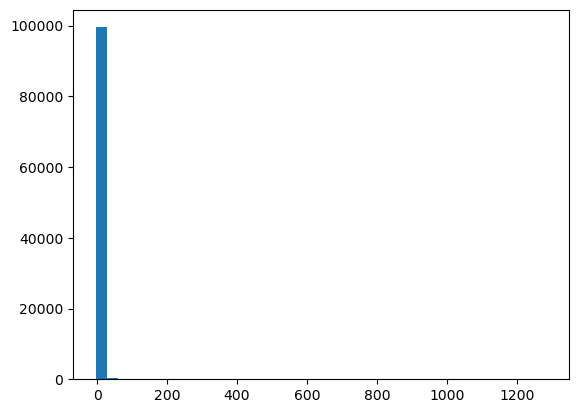

In [96]:
# Ito calculus 결과이용
a,b=0,5
T=b-a
sim,N_interval=100000,500
N=T*N_interval 
s=cp.sqrt(1/N_interval) 

# time 행렬 작성하기
t = cp.linspace(0, T, N).reshape(-1, 1)  
t_mat=cp.tile(t,(1,sim)) # 열 방향으로 sim 개수만큼 복제
# 0으로 이루어진 행을 W의 첫 행에 추가
zero_row = cp.zeros((1, t_mat.shape[1]))
t_mat = cp.vstack([zero_row, t_mat]) # (N+1,sim)의 행렬로 만든다.

# N(0,s)을 따르는 [N, sim] 크기의 정규난수 생성
dW=cp.random.normal(0,s,[N,sim])
# Wt 행렬 만들기
W=cp.cumsum(dW,axis=0)
# 첫 행에 zero vector 추가
zero_row=cp.zeros((1,W.shape[1]))
#(N+1,sim) 행렬로 변환
W=cp.vstack([zero_row,W]) 

Y=cp.exp(W-0.5*t_mat)
mu,sig=norm.fit(Y[-1,:].get()) 
plt.hist(sumW.get(),bins=40)
print('평균:{0}, 분산:{1}'.format(mu,sig**2))

평균: 0.9995937591532206 분산: 102.23693562876834


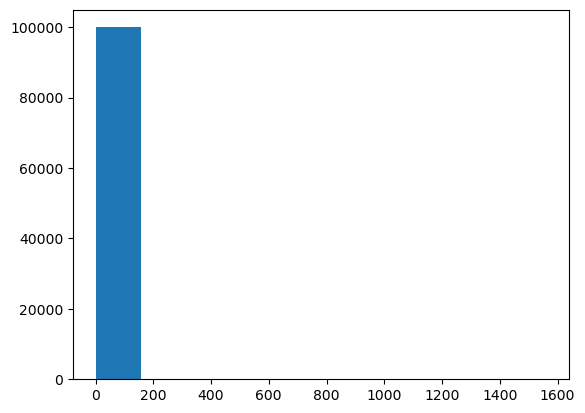

In [97]:
def fun_Y(T,sim,N_intervals):
    import cupy as cp
    from scipy.stats import norm
    import matplotlib.pyplot as plt

    N = T * N_intervals  # 만기를 감안한 시간간격의 갯수
    dt=T/N
    s = cp.sqrt(1 / N_intervals)  # 분산을 표준편차화

    # time 행렬 작성하기
    t_col=cp.arange(1,N+1)*((b-a)/N) # ih의 값 생성
    t_col = t_col[:, cp.newaxis]  # 열(column)로 갖는 행렬로 변환
    t_mat=cp.tile(t_col,(1,sim)) # 열 방향으로 sim 개수만큼 복제
    zero_row = cp.zeros((1, t_mat.shape[1]), dtype=t_mat.dtype)
    # 0으로 이루어진 행을 W의 첫 행에 추가
    t_mat = cp.vstack([zero_row, t_mat]) # (N+1,sim)의 행렬로 만든다.

    # N(0,s)을 따르는 [N, sim] 크기의 정규난수 생성
    dW = cp.random.normal(0, s, size=(N, sim))
    # integrand 부분을 함수형태로 만들어 주기
    W=cp.cumsum(dW,axis=0) # 행으로 계속 누적하여 Wt 행렬 생성
    # 추가할 행 생성
    zero_row = cp.zeros((1, W.shape[1]), dtype=W.dtype)
    # 0으로 이루어진 행을 W의 첫 행에 추가
    W = cp.vstack([zero_row, W]) # (N+1,sim)의 행렬로 만든다.

    # Y값 추출
    Y=cp.exp(W[-1,:]-0.5*t_mat[-1,:])

    return cp.asnumpy(Y)

# sim=100000개수 만큼의 Y값 도출
out=fun_Y(5,100000,500)
plt.hist(out,bins=10)
mu, sig = norm.fit(out)
print('평균:',mu, '분산:',sig**2)

# 	문제. $dN_t = r N_t \, dt + \sigma N_t \, dW_t$ 일 때, $ N_t $를 구하여라. (단, $W_0 = 0$)

평균: 105.13527940368412 분산: 1.9764738872010796


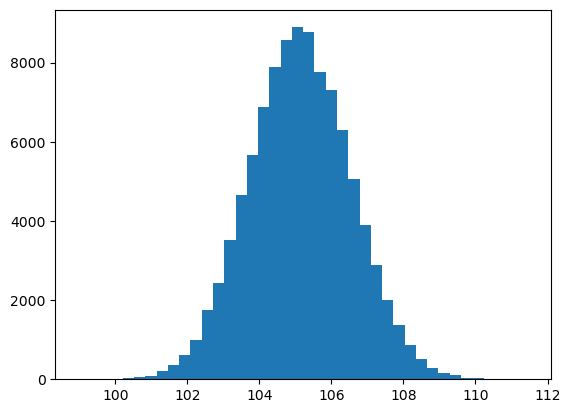

In [98]:
import cupy as cp
from scipy.stats import norm
import matplotlib.pyplot as plt

sim=100000
r,sig=0.05,0.3

# N(0,s)을 따르는 [N, sim] 크기의 정규난수 생성
Z = cp.random.normal(0, s, size=sim)

N = 100*cp.exp(10*(r-0.5*sig**2)+sig*Z)

N_np=cp.asnumpy(N) # numpy array로 변환
plt.hist(N_np,bins=40) # histogram으로 표현
mu, sig = norm.fit(N_np)
print('평균:',mu, '분산:',sig**2)

In [159]:
# 주가 시뮬레이션
def stockprices(N_0, T, r,sig, N_path):
    import numpy as np
  
    h=T/N_path
    s=np.sqrt(h) # 시간간격의 제곱근
    dW = np.random.normal(0, s, N_path)
    
    dlnN =h*(r-0.5*sig**2)+sig*dW
    N=N_0*np.exp(np.cumsum(dlnN))
    
    # 시작점을 N_0로 추가
    N = np.insert(N,0,N_0)
   
    return N

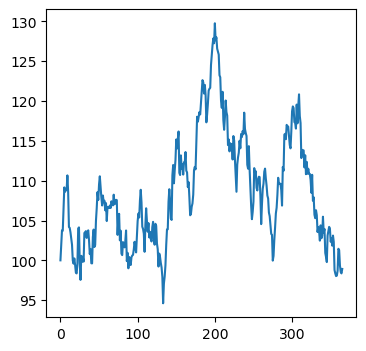

In [161]:
plt.figure(figsize=(4,4))
plt.plot(stockprices(100,1,0.05,0.3,365))
plt.show()

# 	문제. $dN_t = -α N_t \, dt + \sigma \, dW_t$ 일 때, $ N_t $를 구하여라. (단, $W_0 = 0,N_0=10$)